In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import importlib
import cv2 as cv
import sklearn

import findatree.io as io
import findatree.visualize as visual
import findatree.segmentation as segment

importlib.reload(segment)

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define raster-files and print infos

In [2]:
importlib.reload(io)
dir_names=[]
dir_names.extend([r'C:\Data\lwf\DSM_2021'])
dir_names.extend([r'C:\Data\lwf\DTM'])
dir_names.extend([r'C:\Data\lwf\Orthophotos_2021'])

file_names=[]
file_names.extend(['Tnr_11626_D-20210719_DSM.tif'])
file_names.extend(['tnr_11626_dtm.tif'])
file_names.extend(['Tnr_11626_2021_Ortho.tif'])


paths=[os.path.join(dir_names[i],file_name) for i, file_name in enumerate(file_names)]

io.print_raster_info(paths)


(0)
Name: C:/Data/lwf/DSM_2021/Tnr_11626_D-20210719_DSM.tif
Width[px]: 5749
Height[px]: 5423
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-32767.0,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=742322.8121385165, bottom=5457550.352693843, right=742825.1654599565, top=5458024.21981198)
Affine geo-transfrom: [0.087380991727266, 0.0, 742322.8121385165, 0.0, -0.08738099172726485, 5458024.21981198]

(1)
Name: C:/Data/lwf/DTM/tnr_11626_dtm.tif
Width[px]: 461
Height[px]: 425
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-3.4028234663852886e+38,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=742354.9683434721, bottom=5457599.985097144, right=742815.9683434721, top=5458024.985097144)
Affine geo-transfrom: [1.0, 0.0, 742354.9683434721, 0.0, -1.0, 5458024.985097144]

(2)
Name: C:/Data/lwf/Orthophotos_2021/Tnr_11626_2021_Ortho.tif
Width[px]: 8236
Height[px]: 8815
No. of rasters: 5
  Index: 1, dtype: uint16
  I

### Reproject raster-files to same area & resolution

In [3]:
importlib.reload(io)
res = 0.25
bands, mask, A, bound = io.reproject_all_intersect(paths, res=res)

C:\Users\flori\Anaconda3\envs\findatree\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


### Define and normalize channels

In [4]:
##################### Primary channels
chm = (bands[0][:,:,0] - bands[1][:,:,0]).astype(np.float32)

blue = (bands[2][:,:,0] / (2**16 - 1)).astype(np.float32)
green = (bands[2][:,:,1] / (2**16 - 1)).astype(np.float32)
red = (bands[2][:,:,2] / (2**16 - 1)).astype(np.float32)
re = (bands[2][:,:,2] / (2**16 - 1)).astype(np.float32)
nir = (bands[2][:,:,4] / (2**16 - 1)).astype(np.float32)

##################### Secondary channels
# NDVI: Normalized difference vegetation index
NDVI = (nir - red) / (nir + red) 

# RGB
RGB = np.zeros((red.shape[0], red.shape[1], 3), dtype=np.float32)
RGB[:,:,0] = blue
RGB[:,:,1] = green
RGB[:,:,2] = red

# HLS
HLS = cv.cvtColor(RGB, cv.COLOR_RGB2HLS)
H = HLS[:,:,0]
L = HLS[:,:,1]
S = HLS[:,:,2]

### Plotting of channels


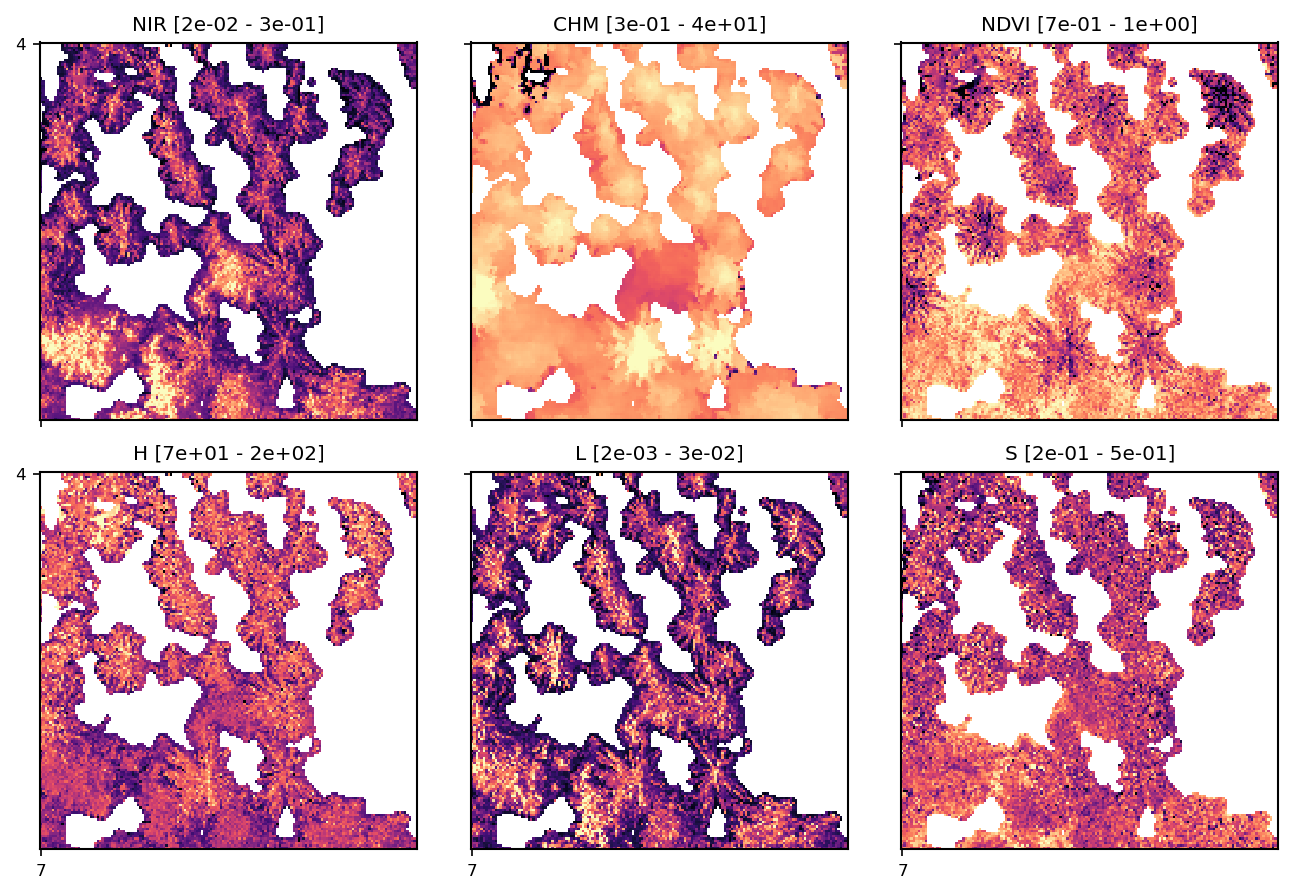

In [5]:
importlib.reload(visual)

# channels = [segment.blur(nir), chm, segment.blur(ndvi), segment.blur(H), segment.blur(L), segment.blur(S)]
channels = [nir, chm, NDVI, H, L, S]

channel_names = ['NIR', 'CHM', 'NDVI', 'H', 'L', 'S']
xylim = [(800, 80), (500, 80)]
boolmask = (segment.blur(chm) < 5) | (segment.blur(NDVI) < 0.6) | (segment.blur(L) < 6e-3)

f, axs = visual.show_channels(
    channels,
    xylim=xylim,
    boolmask=boolmask,
    channel_names=channel_names,
    n_cols_rows=[3,2],
    zoom=1,
)

### Prepare dbscan input

In [6]:
# Zoom into image for testing
xylim = [(800, 40), (500, 40)]
rclim = [
    (xylim[1][0] - xylim[1][1], xylim[1][0] + xylim[1][1]),
    (xylim[0][0] - xylim[0][1], xylim[0][0] + xylim[0][1]),
]

# Get blurred zooms
z = segment.blur(chm[rclim[0][0]:rclim[0][1], rclim[1][0]:rclim[1][1]])  # Height
h = segment.blur(H[rclim[0][0]:rclim[0][1], rclim[1][0]:rclim[1][1]])  # Hue
l = segment.blur(L[rclim[0][0]:rclim[0][1], rclim[1][0]:rclim[1][1]])  # Lightntess
s = segment.blur(S[rclim[0][0]:rclim[0][1], rclim[1][0]:rclim[1][1]])  # Saturation
ndvi = segment.blur(NDVI[rclim[0][0]:rclim[0][1], rclim[1][0]:rclim[1][1]])  # NDVI

# Original shape
shape = z.shape

# Mask
mask = (z > 5) & (ndvi > 0.6) & (l > 6e-3)
r, c = np.where(mask)

# Put data together
#   0: x [m]
#   1: y [m]
#   2: z [m]
#   3: h [0,360]
#   4: l [0,1]
#   5: s [0,1]
#   6: ndvi [-1,1]
data = np.zeros((len(r), 7), dtype=np.float32)
data[:, 0] = c.astype(np.float32) * res 
data[:, 1] = r.astype(np.float32) * res 
data[:, 2] = z[(r,c)]
data[:, 3] = h[(r,c)]
data[:, 4] = l[(r,c)]
data[:, 5] = s[(r,c)]
data[:, 6] = ndvi[(r,c)]


In [9]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

def hls_to_cart(hls):
    h, l, s = hls[0], hls[1], hls[2]

    x = np.cos(h) * s
    y = np.sin(h) * s
    z = l

    xyz = np.array([x, y, z], dtype=np.float32)
    return xyz

def distance(x ,y):
    # Spatial distance
    x_space = x[:2]
    y_space = y[:2]
    d_space = np.linalg.norm(x_space - y_space) / 10

    # HLS color
    x_color = hls_to_cart(x[3:6])
    y_color = hls_to_cart(y[3:6])
    d_color = np.linalg.norm(x_color - y_color) / (2*np.sqrt(2)) 


    # NDVI
    x_ndvi = x[-1]
    y_ndvi = y[-1]
    d_ndvi = np.abs(x_ndvi - y_ndvi) / 0.3

    # Total distance
    d = (d_space + d_color + d_ndvi) / 3

    return d

d = data[np.random.randint(0, len(data), 50), :]

neigh = NearestNeighbors(n_neighbors=400, metric=distance, algorithm='ball_tree')
neigh.fit(data)
# nn_dist, nn_idx = neigh.kneighbors(d)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.neighbors._ball_tree.BinaryTree._query_radius_single'
Traceback (most recent call last):
  File "sklearn\neighbors\_binary_tree.pxi", line 1143, in sklearn.neighbors._ball_tree.BinaryTree.rdist
  File "sklearn\metrics\_dist_metrics.pyx", line 312, in sklearn.metrics._dist_metrics.DistanceMetric.rdist
  File "sklearn\metrics\_dist_metrics.pyx", line 1133, in sklearn.metrics._dist_metrics.PyFuncDistance.dist
  File "sklearn\metrics\_dist_metrics.pyx", line 1141, in sklearn.metrics._dist_metrics.PyFuncDistance._dist
  File "<ipython-input-9-f669894bb427>", line 23, in distance
  File "<__array_function__ internals>", line 5, in norm
  File "C:\Users\flori\Anaconda3\envs\findatree\lib\site-packages\numpy\linalg\linalg.py", line 2529, in norm
    sqnorm = dot(x, x)
  File "<__array_function__ internals>", line 5, in dot
KeyboardInterrupt: 


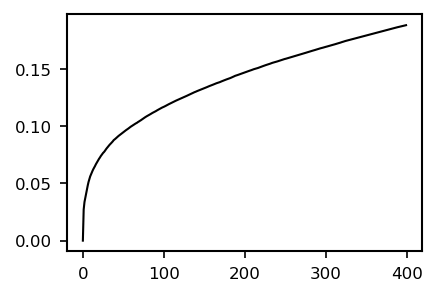

In [ ]:
plt.plot(range(400), np.mean(nn_dist, axis=0))

In [ ]:
clustering = DBSCAN(eps=0.1, min_samples=30, metric='precomputed')
clustering.fit(graph)

### Plotting of segmentation results

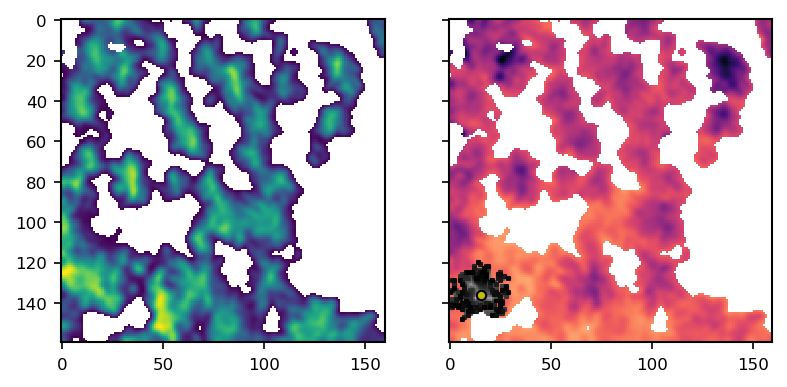

In [ ]:
i = 2
dist = [distance(data[nn_idx[i, 0], :], y) for y in data[nn_idx[i, :], :]]

# Test reconstruction of image from data
f, axs =plt.subplots(figsize=(6,18), ncols=3, sharex=True, sharey=True)
ax = axs[0]
img = np.ones(shape) * np.nan
img[(r,c)] = data[:, 4]
ax.imshow(img)

ax = axs[1]
img = np.ones(shape) * np.nan
img[(r,c)] = data[:, -1]
ax.imshow(img, cmap='magma',vmin=0.7,vmax=1)
ax.scatter(
    data[nn_idx[i, :], 0] / res,
    data[nn_idx[i, :], 1] / res,
    c=dist,
    s=2,
    marker='s',
    cmap='Greys',
)
ax.scatter(
    d[i,0] / res,
    d[i,1] / res,
    s=20,
    color='y',
    ec='k',
    marker='o',
)
    
ax = axs[2]
img = np.ones(shape) * np.nan
img[(r,c)] = data[:, -1]
ax.imshow(img, cmap='magma',vmin=0.7,vmax=1)
ax.scatter(
    data[nn_idx[i, :], 0] / res,
    data[nn_idx[i, :], 1] / res,
    c=dist,
    s=2,
    marker='s',
    cmap='Greys',
)